In [1]:
from rateslib import *

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x121321fd0>])

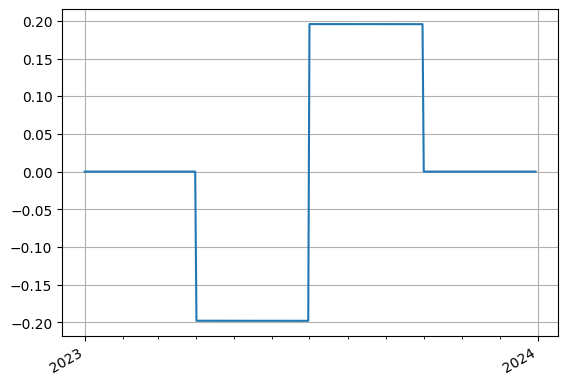

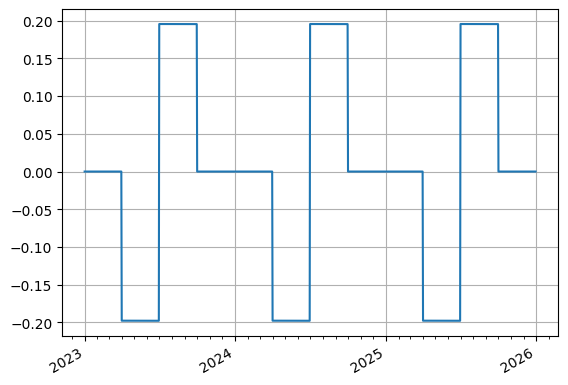

In [17]:
sub2bps = 1-0.0020*0.25
add2bps = 1+0.0020*0.25

season = IndexCurve({
        dt(2023, 1, 1): 1.0,
        dt(2023, 4, 1): 1.0,
        dt(2023, 7, 1): 1.0/sub2bps,
        dt(2023, 10, 1): 1.0/(sub2bps*add2bps),
        dt(2024, 1, 1): 1.0/(sub2bps*add2bps),
    },
    index_base = 100.0,
    index_lag = 3,
)
season.plot("1d")

def repeat_inf_season(icurve: IndexCurve, end: dt) -> IndexCurve:
    nodes = icurve.nodes.copy()
    new_node, new_value, position = list(nodes.keys())[-1], list(nodes.values())[-1], 0
    while new_node < end:
        new_node = add_tenor(new_node, "3m", None, None)
        new_value = new_value * list(nodes.values())[position + 1] / list(nodes.values())[position]
        position += 1
        nodes.update({new_node:  new_value})

    return IndexCurve(nodes, index_base=icurve.index_base, index_lag=3)

season = repeat_inf_season(season, dt(2026, 1, 1))
season.plot("1d")

In [18]:
unadjusted_inf = IndexCurve(
    {
        dt(2023, 1, 1): 1.0, 
        dt(2024, 1, 1): 1.0, 
        dt(2025, 1, 1): 1.0,
        dt(2026, 1, 1): 1.0,
    },
    index_lag=3,
    index_base=100.0,
    id="eurcpi_unadj",
)
adjusted_inf = CompositeCurve(
    [unadjusted_inf, season],
    id="eurcpi_adj",
)
discount = Curve({
        dt(2023, 1, 1): 1.0, 
        dt(2024, 1, 1): 1.0, 
        dt(2025, 1, 1): 1.0,
        dt(2026, 1, 1): 1.0,
    },
    id="eureur"
)

instruments = [
    IRS(dt(2023, 1, 1), "1Y", "A", curves="eureur"),
    IRS(dt(2023, 1, 1), "2Y", "A", curves="eureur"),
    IRS(dt(2023, 1, 1), "3Y", "A", curves="eureur"),
    ZCIS(dt(2023, 1, 1), "1Y", "A", curves=["eureur", "eureur", "eurcpi_adj", "eureur"]),
    ZCIS(dt(2023, 1, 1), "2Y", "A", curves=["eureur", "eureur", "eurcpi_adj", "eureur"]),
    ZCIS(dt(2023, 1, 1), "3Y", "A", curves=["eureur", "eureur", "eurcpi_adj", "eureur"]),
]

solver = Solver(
    curves=[discount, unadjusted_inf, adjusted_inf],
    instruments=instruments,
    s=[3.25, 3.1, 2.9, 1.8, 1.74, 1.69]
)


SUCCESS: `func_tol` reached after 3 iterations (gauss_newton) , `f_val`: 2.805853374881185e-17, `time`: 0.0237s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x12144e550>])

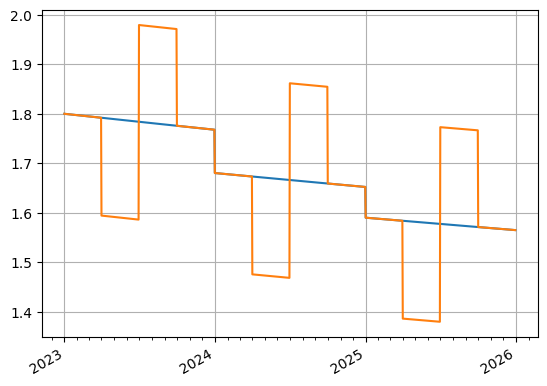

In [19]:
unadjusted_inf.plot("1d", comparators=[adjusted_inf])

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x12165acd0>])

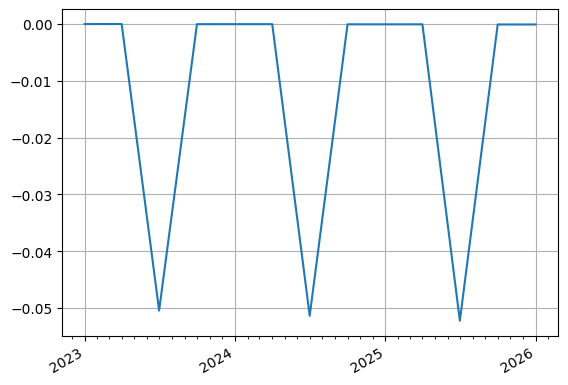

In [21]:
unadjusted_inf.plot_index(comparators=[adjusted_inf], difference=True)